People accused of a crime, also known as criminal defendants, have to wait days or even weeks for their case to come before a jury or judge who will decide if they are guilty or innocent. During this waiting period, the defendant may be released (potentially on bail) or they may be required to wait in jail. Judges make this decision based on their assessment of 1) how likely the defendent is to recommit a crime before the trial and 2) how likely the defendant is to show up for the trial. If the judge believes the defendant is likely to either recommit a crime or to flee the trial, they will deny the defendant 

We will be using the COMPAS dataset on **recidivism** (recommiting a crime) for criminal defendents from Broward County, Florida. COMPAS (Correctional Offender Management Profiling for Alternative Sanctions)  is a algorithmic tool used to create risk scores that judges use to determine who gets pre-trial release. [Propublica's analysis](https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing) of this dataset alleged that COMPAS is racially biased. These allegations sparked a national conversation on what it means for an algorithm to be fair. In this project, we will explore the dataset, definitions of fairness, and we will see how well various classifiers satisfy these notions of fairness.

This is jupyter notebook. It is an interactive way to run code. Many of the cells have complete code; you just need to run them by clicking on the cell and either selecting the play buttom above or using the keyboard shortcut *shift + enter*. 

Some cells require you to write the code. These are indicated by a **TODO** flag above the cell.

In this notebook you will become familiar with the COMPAS data and you will perform some data analysis.

Import the libraries for analysis. 

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 

Let's read in the data and look at the first few rows

In [39]:
dat = pd.read_csv("./compas-scores-two-years.csv", index_col=0)
dat.head()

,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,juv_fel_count,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
id,,,,,,,,,,,,,,,,,,,,,
1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,0,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,0,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,0,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,0,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,0,...,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0


Each row gives the data for a particular person. Each column gives an attribute which we may use as a predictor or as an outcome in our model. How many rows and columns are there?

In [12]:
n, p = dat.shape
print("Number of rows is {}. Number of columns is {}".format(n,p))

Number of rows is 7214. Number of columns is 53


What are the names of the columns? This tells us what information is contained in our dataset.

In [42]:
dat.columns

Index(['name', 'first', 'last', 'compas_screening_date', 'sex', 'dob', 'age',
       'age_cat', 'race', 'juv_fel_count', 'decile_score', 'juv_misd_count',
       'juv_other_count', 'priors_count', 'days_b_screening_arrest',
       'c_jail_in', 'c_jail_out', 'c_case_number', 'c_offense_date',
       'c_arrest_date', 'c_days_from_compas', 'c_charge_degree',
       'c_charge_desc', 'is_recid', 'r_case_number', 'r_charge_degree',
       'r_days_from_arrest', 'r_offense_date', 'r_charge_desc', 'r_jail_in',
       'r_jail_out', 'violent_recid', 'is_violent_recid', 'vr_case_number',
       'vr_charge_degree', 'vr_offense_date', 'vr_charge_desc',
       'type_of_assessment', 'decile_score.1', 'score_text', 'screening_date',
       'v_type_of_assessment', 'v_decile_score', 'v_score_text',
       'v_screening_date', 'in_custody', 'out_custody', 'priors_count.1',
       'start', 'end', 'event', 'two_year_recid'],
      dtype='object')

<span style="color:red">ADD explanations for variables or include a link to a data dictionary if one exists</span>

The **prevalence** or **base rate** describes how often the outcome of interest occurs. Our outcome of interest is *two_year_recid* which indicates whether the defendant was rearrested for a crime within 2 years. *two_year_recid =1* if the defendent was rearrested and 0 if the defendant was not. What's the base rate for *two_year_recid*?

In [31]:
recid_rate = dat.two_year_recid.mean() #This is equivalent to dat['two_year_recid'].mean()
print("The recidivism base rate is {0:.3f}. This means that {1:00.1f}% of defendants were rearrested".format(recid_rate, recid_rate*100))

The recidivism base rate is 0.451. This means that 45.1% of defendants were rearrested


There are concerns of racial bias in the criminal justice system. So let's see what the base rate is for *Caucasian* defendants. We will filter the dataset to only rows whose *race* column = 'Caucasian' and compute the mean two-year recidivism rate.

In [36]:
recid_rate_white = dat[dat.race == 'Caucasian'].two_year_recid.mean()
print("The recidivism base rate for Caucasian defendants is {0:.3f}.".format(recid_rate_white))

The recidivism base rate for Caucasian defendants is 0.394.


**TODO**: What's the base rate for *African-American* defendants? 

Hint: You will use the same code as above but change 'Caucasian' to the value for African-American defendants. You may wonder what this value is in the dataset. Is it 'African-American' or 'African_American' or something else? To answer this, use the below code to see all unique values of the *race* column

In [38]:
dat.race.unique()

array(['Other', 'African-American', 'Caucasian', 'Hispanic',
       'Native American', 'Asian'], dtype=object)

Are the base rates different by race? How significant is this difference? To answer this, we can compute a 95% confidence interval. <span style="color:red">ADD. Explain more why we need the 95% confidence interval, add code for computing the confidence intervals, and add outline of code to visualize the differences in base rates with 95% confidence intervals </span>

Why might the base rates be different for different races? Can you provide two or more possible explanations?

*your answer here*

In subsequent notebooks we will use this dataset to train a model that will make risk scores for how likely a defendant is to recommit a crime. Do you think there may be any problems in using a dataset in which the base rates differ by race?

*your answer here*

Our model will use some of the columns to predict the outcome *two_year_recid*. The columns that we use to predict the outcome are called *features*. We should not include all of the columns as features. Why might we exclude some columns? Can you name at least three columns that we should include as features and at least two columns that we should not include as features? 

*your answer here*

*priors_count* is an example of a column that we should include as a feature. This tells us how many times the defendant has been previously arrested. Since the past is a good indication of the future, this is a useful feature for predicting how likely they are to recommit a crime. 

Let's try to understand this feature better.

In [43]:
dat.priors_count.describe()

count    7214.000000
mean        3.472415
std         4.882538
min         0.000000
25%         0.000000
50%         2.000000
75%         5.000000
max        38.000000
Name: priors_count, dtype: float64

<span style="color:red">ADD explanation of each of these ^ and code to visualize a scatter plot</span>

Does *priors_count* differ by race?

**TODO** compute the mean *priors_count* for African-American and for Caucasian. **Extra** compute the median *priors_count* by race. What do the means (and medians if you computed them) tell us about prior criminal history by race?

Age is also highly predictive of crime. Younger people are more likely to commit crimes. Let's look at *age_cat* which discretizes age into three categories. How common is each?

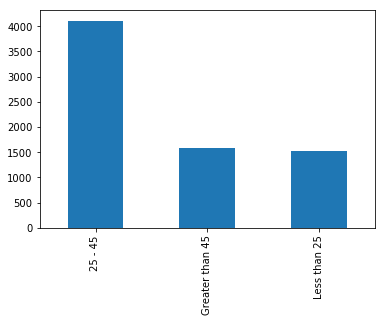

In [62]:
dat.age_cat.value_counts().plot.bar()

Do the age distributions differ by race?

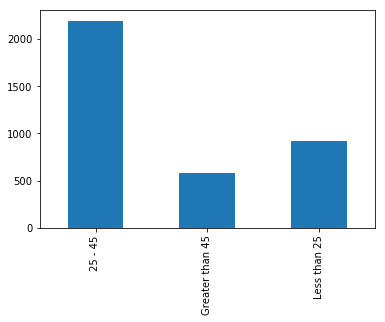

In [79]:
dat[dat.race=='African-American'].age_cat.value_counts().sort_index().plot.bar()

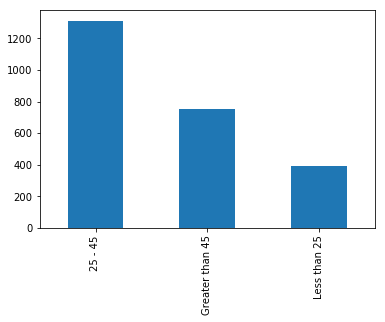

In [80]:
dat[dat.race=='Caucasian'].age_cat.value_counts().sort_index().plot.bar()

In [ ]:
# are the age distributions different by race?

In [69]:
dat.groupby(['race', 'age_cat']).size().unstack()

age_cat,25 - 45,Greater than 45,Less than 25
race,,,
African-American,2194,582,920
Asian,14,11,7
Caucasian,1312,752,390
Hispanic,367,143,127
Native American,12,3,3
Other,210,85,82


In [76]:
dat.groupby('race').mean()

,age,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_days_from_compas,is_recid,r_days_from_arrest,violent_recid,is_violent_recid,decile_score.1,v_decile_score,priors_count.1,start,end,event,two_year_recid
race,,,,,,,,,,,,,,,,,,,
African-American,32.740801,0.100108,5.368777,0.136364,0.135011,4.438853,5.190557,72.087605,0.550866,19.529933,NaN,0.133929,5.368777,4.391234,4.438853,13.959957,504.777056,0.435065,0.514340
Asian,37.781250,0.000000,2.937500,0.031250,0.031250,1.437500,-4.843750,1.812500,0.343750,0.166667,NaN,0.125000,2.937500,2.437500,1.437500,21.781250,747.343750,0.250000,0.281250
Caucasian,37.726569,0.026487,3.735126,0.041972,0.092095,2.586797,-0.120690,36.843610,0.417685,22.033803,NaN,0.090465,3.735126,2.948655,2.586797,8.609209,589.662999,0.332518,0.393643
Hispanic,35.455259,0.032967,3.463108,0.039246,0.067504,2.252747,2.429795,72.448494,0.384615,17.676056,NaN,0.087912,3.463108,3.034537,2.252747,9.365777,631.894819,0.323391,0.364207
Native American,32.888889,0.277778,6.166667,0.055556,0.222222,6.000000,-10.187500,54.470588,0.611111,76.666667,NaN,0.222222,6.166667,4.611111,6.000000,3.111111,485.111111,0.333333,0.555556
Other,35.013263,0.063660,2.949602,0.058355,0.042440,1.875332,10.147222,33.212766,0.379310,19.242424,NaN,0.100796,2.949602,2.846154,1.875332,8.665782,648.909814,0.312997,0.352785
